<h1><u>Final Analysis </u></h1>

### 1. Security Implications in the Data and addressing PII data 
### 2. Regional Segmentation of the data
### 3. Spending Habits Per Region
### 4. Creating Exclusion Flag for Customers with less than 5 orders 
### 5. Creating Customer Profiles 
### 6. Usage frequency and expenditure across the customers profiles( min, max, mean) 
### 7. Customer Profiles in Comparison with Region & Departments
### 8. Connection between age and family Status

In [4]:
## importing libraries & data 
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy 

path = r'/Users/aahamoustafa/Desktop/Data Projects/Instacart Basket Analysis  12-2024'

ords_prods_cust_excluded = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'ords_prods_cust_final.pkl'))
dept = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'departments_wrangled.csv'))

In [6]:
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format
ords_prods_cust_excluded.head()

,order_id,user_id,order_number,order_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,...,State,Age,date_joined,n_dependants,fam_status,income,Region,Customers_Exclusion,customer_profile,department
0,2539329,1,1,2,8,NaN,196,1,0,Soda,...,Alabama,31,2/17/2019,3,married,40423,South,Included,Parent,beverages
1,2539329,1,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,...,Alabama,31,2/17/2019,3,married,40423,South,Included,Parent,dairy eggs
2,2539329,1,1,2,8,NaN,12427,3,0,Original Beef Jerky,...,Alabama,31,2/17/2019,3,married,40423,South,Included,Parent,snacks
3,2539329,1,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,...,Alabama,31,2/17/2019,3,married,40423,South,Included,Parent,snacks
4,2539329,1,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,...,Alabama,31,2/17/2019,3,married,40423,South,Included,Parent,household


## 1. Any Security Implications in the data?

we have sensitive customer data providing each customers first name, last name - we will drop them as they wont be used in our analysis so the data cant be traced back to them

In [13]:
ords_prods_cust.drop(columns = ['first_name','surname'], inplace = True)

## 2. Regional Segmentation of the Data 

In [15]:
# Define the regions
northeast = ["Maine", "New Hampshire", "Vermont", "Massachusetts", 
             "Rhode Island", "Connecticut", "New York", "Pennsylvania", "New Jersey"]

midwest = ["Wisconsin", "Michigan", "Illinois", "Indiana", "Ohio", 
           "North Dakota", "South Dakota", "Nebraska", "Kansas", 
           "Minnesota", "Iowa", "Missouri"]

south = ["Delaware", "Maryland", "District of Columbia", "Virginia", 
         "West Virginia", "North Carolina", "South Carolina", 
         "Georgia", "Florida", "Kentucky", "Tennessee", 
         "Mississippi", "Alabama", "Oklahoma", "Texas", 
         "Arkansas", "Louisiana"]

west = ["Idaho", "Montana", "Wyoming", "Nevada", "Utah", 
        "Colorado", "Arizona", "New Mexico", "Alaska", 
        "Washington", "Oregon", "California", "Hawaii"]

# Create a new column 'region' based on the state
region = []

for value in ords_prods_cust['State']:
    if value in northeast:
        region.append("Northeast")
    elif value in midwest:
        region.append("Midwest")
    elif value in south:
        region.append("South")
    elif value in west:
        region.append("West")
    else:
        region.append("Unknown")

# Add the new column to your DataFrame
ords_prods_cust['Region'] = region

## 3. Spending Habits Per Region

In [29]:
## grouping by region and checking the spending flag counts in each region
ords_prods_cust_excluded.groupby(['Region','spending_flag'])['spending_flag'].count()

Region     spending_flag
Midwest    High Spender        24085
           Low spender       7237428
Northeast  High Spender        15058
           Low spender       5449627
South      High Spender        33261
           Low spender      10277878
West       High Spender        25039
           Low spender       7902188
Name: spending_flag, dtype: int64

#### Customers in the South tend to purchase more products and have the highest spenders

In [37]:
## grouping by region and checking average price per region
ords_prods_cust.groupby('Region')['average_price'].mean()

Region
Midwest      7.792584
Northeast    7.782411
South        7.794917
West         7.790356
Name: average_price, dtype: float64

#### Almost identical means & medians of their average_price across all regions

## 4. Exclusion Flag for Low Activity Customers ( < 5 orders)

In [39]:
## creating exclusion column 
ords_prods_cust.loc[ords_prods_cust['max_order'] < 5, 'Customers_Exclusion'] = 'Excluded'
ords_prods_cust.loc[ords_prods_cust['max_order'] >= 5, 'Customers_Exclusion'] = 'Included'

In [41]:
## filtering the data 
ords_prods_cust_excluded = ords_prods_cust[ords_prods_cust['Customers_Exclusion'] == 'Included']

In [43]:
## exporting the data
ords_prods_cust_excluded.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'ords_prods_cust_excluded.pkl'))

## 5. Creating Customer Profiles

In [52]:
# Initialize 'customer_profile' with a default value
ords_prods_cust_excluded['customer_profile'] = 'General Shopper'

# Single Adult: Young adults with no dependents
ords_prods_cust_excluded.loc[(ords_prods_cust_excluded['Age'] <= 30) & (ords_prods_cust_excluded['n_dependants'] == 0), 'customer_profile'] = 'Single Adult'

# Parent: Customers with at least one dependent
ords_prods_cust_excluded.loc[ ords_prods_cust_excluded['n_dependants'] >= 1, 'customer_profile'] = 'Parent'

# Senior: Customers aged 65 and older
ords_prods_cust_excluded.loc[ ords_prods_cust_excluded['Age'] >= 65, 'customer_profile'] = 'Senior'

### Customer Profile Distribution

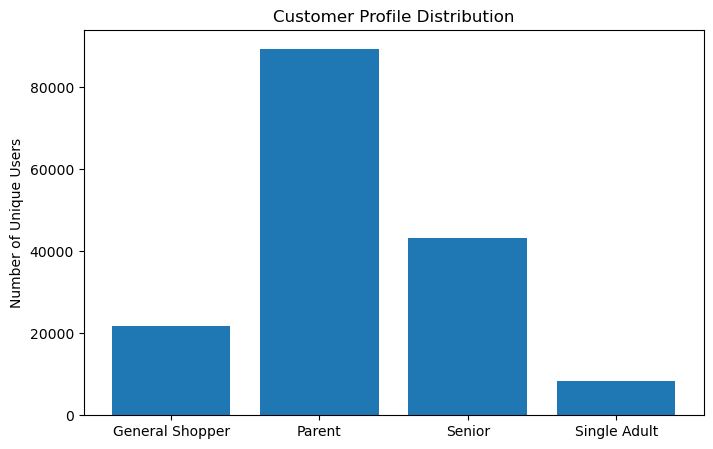

customer_profile    General ShopperParentSeniorSingle Adult
user_count                                           162631
dtype: object

In [56]:
# Group by 'customer_profile' and count unique users
customer_counts = ords_prods_cust_excluded.groupby('customer_profile')['user_id'].nunique().reset_index()

# Rename columns for clarity
customer_counts.rename(columns={'user_id': 'user_count'}, inplace=True)

# Bar Chart
plt.figure(figsize=(8, 5))
plt.bar(customer_counts['customer_profile'], customer_counts['user_count'])
plt.title('Customer Profile Distribution')
plt.ylabel('Number of Unique Users')
plt.xticks(rotation= 0)
plt.savefig("/Users/aahamoustafa/Desktop/Data Projects/Instacart Basket Analysis  12-2024/04 Analysis /Visualizations/Customer Profile Distribution.png")
plt.show()

### Avg Income across the Profiles?

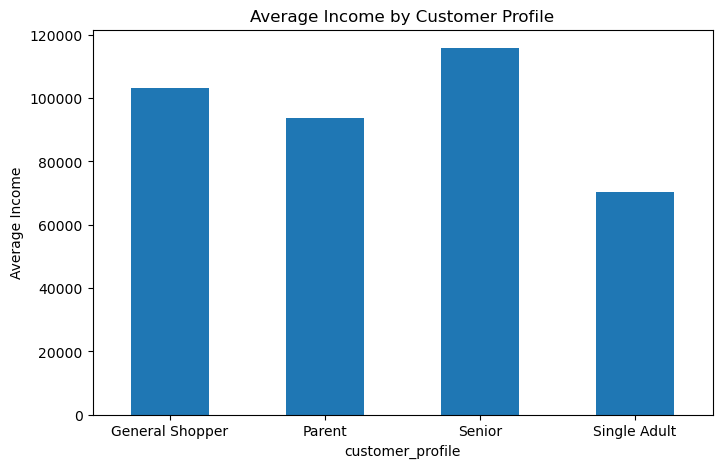

In [67]:
avg_income = ords_prods_cust_excluded.groupby('customer_profile')['income'].mean()

# Bar Chart
plt.figure(figsize=(8, 5))
avg_income.plot(kind='bar')
plt.title('Average Income by Customer Profile')
plt.ylabel('Average Income')
plt.xticks(rotation=0)
plt.savefig("/Users/aahamoustafa/Desktop/Data Projects/Instacart Basket Analysis  12-2024/04 Analysis /Visualizations/Avg Income Across Customer Profiles.png")
plt.show()

## 6. Usage frequency and expenditure across the customers profiles & Region( min, max, mean)

In [75]:
# Group by customer_profile and calculate statistics
profile_stats = ords_prods_cust_excluded.groupby('customer_profile').agg(
    max_usage_frequency=('max_order', 'max'),
    mean_usage_frequency=('max_order', 'mean'),
    min_usage_frequency=('max_order', 'min'),
    max_expenditure=('prices', 'max'),
    mean_expenditure=('prices', 'mean'),
    min_expenditure=('prices', 'min')
).reset_index()
profile_stats

,customer_profile,max_usage_frequency,mean_usage_frequency,min_usage_frequency,max_expenditure,mean_expenditure,min_expenditure
0,General Shopper,99,35.056090,5,25.0,7.789980,1.0
1,Parent,99,34.361748,5,25.0,7.789470,1.0
2,Senior,99,34.326709,5,25.0,7.796714,1.0
3,Single Adult,99,33.973688,5,25.0,7.772443,1.0


In [23]:
# Group by Region and calculate statistics
region_stats = ords_prods_cust_excluded.groupby('Region').agg(
    max_usage_frequency=('max_order', 'max'),
    mean_usage_frequency=('max_order', 'mean'),
    min_usage_frequency=('max_order', 'min'),
    max_expenditure=('prices', 'max'),
    mean_expenditure=('prices', 'mean'),
    min_expenditure=('prices', 'min')
).reset_index()
region_stats

,Region,max_usage_frequency,mean_usage_frequency,min_usage_frequency,max_expenditure,mean_expenditure,min_expenditure
0,Midwest,99,33.930750,5,25.0,7.792318,1.0
1,Northeast,99,34.604733,5,25.0,7.781442,1.0
2,South,99,34.482436,5,25.0,7.794439,1.0
3,West,99,34.681821,5,25.0,7.790308,1.0


### 7. Customer Profiles in Comparison with Region & Departments

In [ ]:
# Group data by region and customer profiles

region_profile = ords_prods_cust_excluded.groupby(['Region','customer_profile'])['user_id'].nunique().reset_index()
region_profile.rename(columns={'user_id': 'user_count'}, inplace=True)

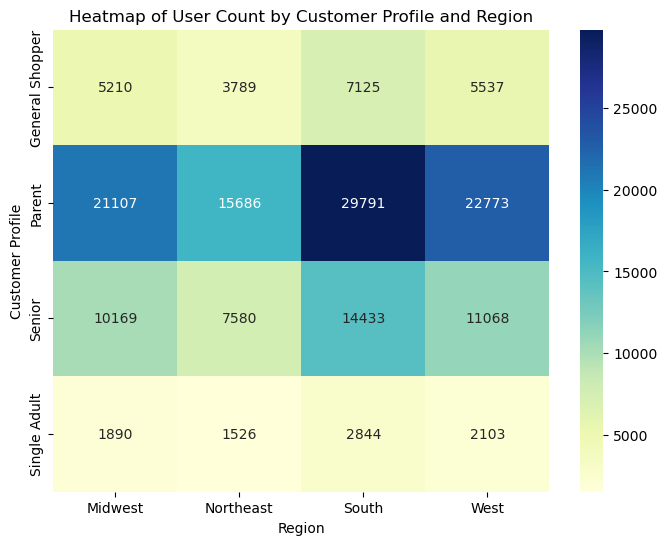

In [111]:
## visualizing Region vs customer profile

# Pivot data for heatmap
heatmap_data = region_profile.pivot(index='customer_profile', columns='Region', values='user_count')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of User Count by Customer Profile and Region')
plt.xlabel('Region')
plt.ylabel('Customer Profile')
plt.savefig("/Users/aahamoustafa/Desktop/Data Projects/Instacart Basket Analysis  12-2024/04 Analysis /Visualizations/heatmap of user count by Customer Profile & Region.png")
plt.show()

In [5]:
## merging department data 
dept.rename(columns={'Unnamed: 0': 'department_id'}, inplace=True)
ords_prods_cust_excluded = pd.merge(ords_prods_cust_excluded, dept, on='department_id')

In [9]:
## grouping by department 
department_profile = ords_prods_cust_excluded.groupby(['department','customer_profile'])['user_id'].nunique().reset_index()
department_profile.rename(columns={'user_id': 'user_count'}, inplace=True)

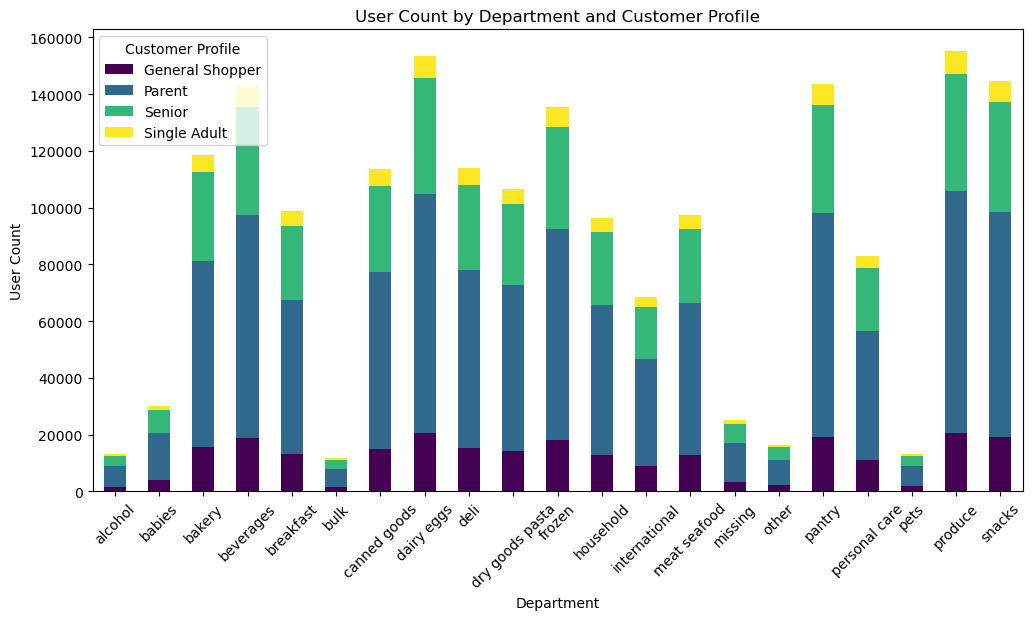

In [17]:
# Pivot data for stacked bar chart
stacked_data = department_profile.pivot(index='department', columns='customer_profile', values='user_count')

# Plot stacked bar chart
stacked_data.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('User Count by Department and Customer Profile')
plt.xlabel('Department')
plt.ylabel('User Count')
plt.xticks(rotation=45)
plt.legend(title='Customer Profile')
plt.savefig("/Users/aahamoustafa/Desktop/Data Projects/Instacart Basket Analysis  12-2024/04 Analysis /Visualizations/User Count by Department and Customer Profile.png")
plt.show()


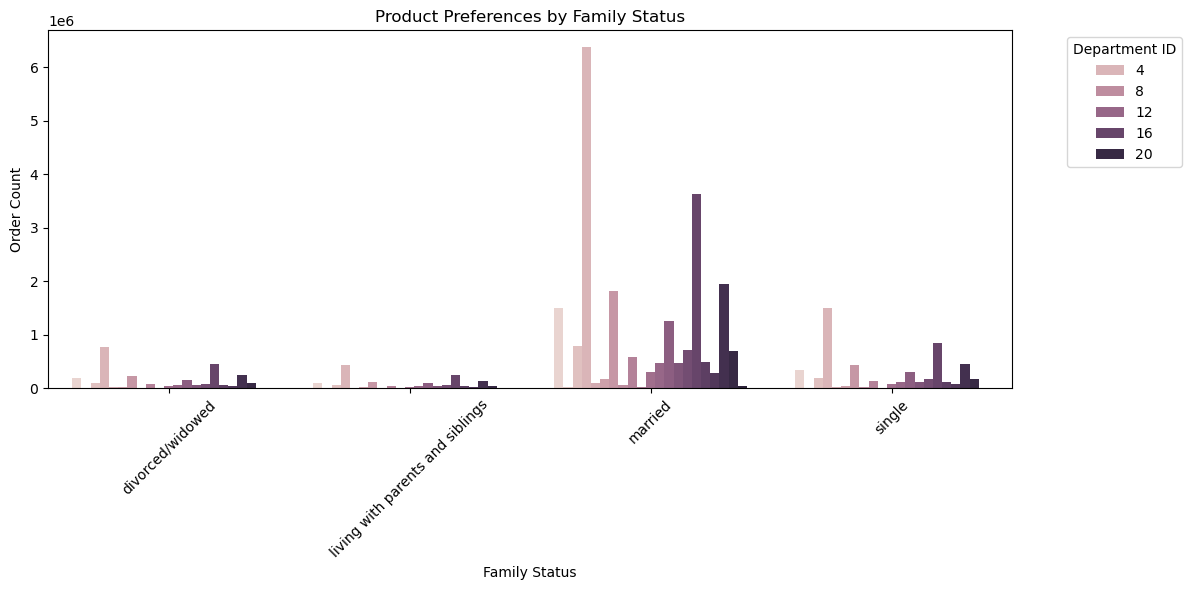

In [59]:
# Group by family status and department
product_preferences_by_status = ords_prods_cust_excluded.groupby(['fam_status', 'department_id']).size().reset_index(name='order_count')

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(data=product_preferences_by_status, x='fam_status', y='order_count', hue='department_id')
plt.title('Product Preferences by Family Status') 
plt.xlabel('Family Status')
plt.ylabel('Order Count')
plt.legend(title='Department ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
